In [93]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from os.path import isfile, join
from pandas.api.types import CategoricalDtype
from torch.nn.functional import cosine_similarity
from sklearn.model_selection import train_test_split

# Data Processing and Feature creation

In [94]:
data = pd.read_csv("./data/transactions.csv")
data["t_dat"] = pd.to_datetime(data.t_dat).dt.date

relevance = pd.read_csv("./data/relevance.csv")
item = pd.read_csv("./data/articles.csv")
customer = pd.read_csv("./data/customers.csv")

In [95]:
days_since_purchase = (
    data.groupby(["customer_id", "article_id"])["t_dat"]
    .max()
    .reset_index(name="days_since_purchase")
)
days_since_purchase["days_since_purchase"] = (
    data.t_dat.max() - days_since_purchase["days_since_purchase"]
).dt.days

item_popularity = data.groupby("article_id").size().reset_index(name="popularity")

In [96]:
# creating label 1 data
data["label"] = 1
data = data[["customer_id", "article_id", "label"]].copy()
data = data.merge(relevance, on=["customer_id", "article_id"], how="left")
data.head()

,customer_id,article_id,label,u2i_score,cf_score,co_occurence,count
0,001ea4e9c54f7e9c88811260d954edc059d596147e1cf8...,652075001,1,0.0,0.125000,3.0,2.0
1,001ea4e9c54f7e9c88811260d954edc059d596147e1cf8...,670295001,1,0.0,0.190476,0.0,1.0
2,01624a723db9eb160f1ce8148eea035963527b2ddca181...,547367007,1,0.0,0.000000,3.0,1.0
3,030b237f78cdd4df9a13c92900a82db7a18afc7556f2c1...,610730016,1,NaN,NaN,NaN,NaN
4,040127192a2fd9ac2a7cbf9dd4cf452eea91f230b55b60...,649671004,1,0.0,0.000000,3.0,1.0


In [97]:
# remove items already transacted by user
relevance = relevance.groupby("customer_id", sort=False).head(500)
relevance = relevance.merge(
    data[["customer_id", "article_id"]].drop_duplicates(),
    on=["customer_id", "article_id"],
    how="left",
    indicator=True,
)
relevance = relevance[relevance["_merge"] == "left_only"].drop("_merge", axis=1)
relevance["label"] = 0

In [98]:
final = pd.concat([data, relevance]).drop_duplicates()
final.head(2)

,customer_id,article_id,label,u2i_score,cf_score,co_occurence,count
0,001ea4e9c54f7e9c88811260d954edc059d596147e1cf8...,652075001,1,0.0,0.125000,3.0,2.0
1,001ea4e9c54f7e9c88811260d954edc059d596147e1cf8...,670295001,1,0.0,0.190476,0.0,1.0


In [99]:
final = (
    final.merge(customer, on="customer_id", how="left")
    .merge(days_since_purchase, on=["customer_id", "article_id"], how="left")
    .merge(item_popularity, on="article_id", how="left")
)
final.head()

,customer_id,article_id,label,u2i_score,cf_score,co_occurence,count,club_member_status,age,postal_code,days_since_purchase,popularity
0,001ea4e9c54f7e9c88811260d954edc059d596147e1cf8...,652075001,1,0.0,0.125000,3.0,2.0,ACTIVE,25.0,63c82aec4da25b6b5f967abe4e17d112b24e53643e916d...,733.0,7
1,001ea4e9c54f7e9c88811260d954edc059d596147e1cf8...,670295001,1,0.0,0.190476,0.0,1.0,ACTIVE,25.0,63c82aec4da25b6b5f967abe4e17d112b24e53643e916d...,733.0,1
2,01624a723db9eb160f1ce8148eea035963527b2ddca181...,547367007,1,0.0,0.000000,3.0,1.0,ACTIVE,21.0,f9869ea337f940331834a17bb1970b06cbf63bbc8ccdf0...,733.0,48
3,030b237f78cdd4df9a13c92900a82db7a18afc7556f2c1...,610730016,1,NaN,NaN,NaN,NaN,ACTIVE,25.0,e77c297ec43cef46d20c3694de10fe7c930a2a9f60eb0d...,733.0,20
4,040127192a2fd9ac2a7cbf9dd4cf452eea91f230b55b60...,649671004,1,0.0,0.000000,3.0,1.0,ACTIVE,46.0,4fb304f3138ef07381160b249016bbb05f2e10b875fa85...,733.0,6


In [100]:
categorical_dtypes = dict()
catagorical_columns = ["article_id", "club_member_status", "postal_code"]
final["club_member_status"] = final["club_member_status"].fillna("PRE-CREATE")

for column in catagorical_columns:
    categorical_dtypes[column] = CategoricalDtype(
        categories=set(final[column].unique())
    )

final = final.astype(categorical_dtypes)
final[catagorical_columns].dtypes

article_id            category
club_member_status    category
postal_code           category
dtype: object

# Training

In [101]:
train, valid = train_test_split(final, test_size=0.2, random_state=42)
train.shape, valid.shape

((3129353, 12), (782339, 12))

In [102]:
def train_binary_model(train, feats, valid, model_path, cat_features, params):
    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=200,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_path,
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [104]:
params = {
    "objective": "binary",
    "boosting_type": "dart",
    "metric": "auc",
    "max_depth": 16,
    "num_leaves": 128,
    "learning_rate": 0.03,
    "verbose": -1,
    "eval_at": 5,
    "feature_fraction": 0.05,
    "num_threads": 16,
}

features = [
    "article_id",
    "club_member_status",
    "postal_code",
    "popularity",
    "u2i_score",
    "cf_score",
    "age",
    "co_occurence",
    "count",
    "days_since_purchase",
]

cat_features = [0, 1, 2]

In [ ]:
ranker = train_binary_model(
    train=train,
    feats=features,
    valid=valid,
    model_path="./ranker.pt",
    cat_features=cat_features,
    params=params,
)

<Axes: xlabel='importance', ylabel='feature'>

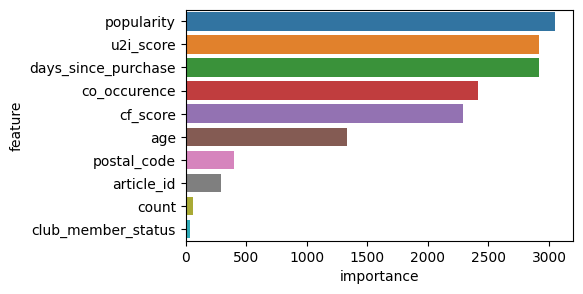

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

feat_importance = pd.DataFrame(
    {"feature": features, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)

plt.figure(figsize=(5, 3))
sns.barplot(y="feature", x="importance", data=feat_importance)

# Infer

In [109]:
relevance = pd.read_csv("./data/relevance.csv")
relevance = (
    relevance.merge(customer, on="customer_id", how="left")
    .merge(days_since_purchase, on=["customer_id", "article_id"], how="left")
    .merge(item_popularity, on="article_id", how="left")
)
relevance.head()

,customer_id,article_id,u2i_score,cf_score,co_occurence,count,club_member_status,age,postal_code,days_since_purchase,popularity
0,000fa62c9e64d11bc25c530736949fd8dfc9a39d50c453...,111586001,0.0,0.0,6.0,1,ACTIVE,17.0,2fef3a55e3348e44344abef921b505b6f0667084e0777d...,NaN,174
1,000fa62c9e64d11bc25c530736949fd8dfc9a39d50c453...,156231001,0.0,0.0,6.0,1,ACTIVE,17.0,2fef3a55e3348e44344abef921b505b6f0667084e0777d...,NaN,230
2,000fa62c9e64d11bc25c530736949fd8dfc9a39d50c453...,160442010,0.0,0.0,5.0,1,ACTIVE,17.0,2fef3a55e3348e44344abef921b505b6f0667084e0777d...,NaN,154
3,000fa62c9e64d11bc25c530736949fd8dfc9a39d50c453...,188183015,0.0,0.0,2.0,1,ACTIVE,17.0,2fef3a55e3348e44344abef921b505b6f0667084e0777d...,NaN,18
4,000fa62c9e64d11bc25c530736949fd8dfc9a39d50c453...,188183016,0.0,0.0,2.0,1,ACTIVE,17.0,2fef3a55e3348e44344abef921b505b6f0667084e0777d...,NaN,19


In [110]:
relevance["club_member_status"] = relevance["club_member_status"].fillna("PRE-CREATE")
relevance = relevance.astype(categorical_dtypes)
relevance[catagorical_columns].dtypes

article_id            category
club_member_status    category
postal_code           category
dtype: object

In [111]:
relevance["prediction"] = ranker.predict(relevance[features])
relevance.sort_values(
    ["customer_id", "prediction"], ascending=[True, False], inplace=True
)
relevance = relevance[["customer_id", "article_id", "prediction"]].copy()
relevance.head()

,customer_id,article_id,prediction
100,000fa62c9e64d11bc25c530736949fd8dfc9a39d50c453...,706016001,0.295500
138,000fa62c9e64d11bc25c530736949fd8dfc9a39d50c453...,748355006,0.240829
137,000fa62c9e64d11bc25c530736949fd8dfc9a39d50c453...,748355002,0.239778
34,000fa62c9e64d11bc25c530736949fd8dfc9a39d50c453...,524529004,0.206053
44,000fa62c9e64d11bc25c530736949fd8dfc9a39d50c453...,554479001,0.196813


# Qualitative Analysis

In [112]:
transaction = pd.read_csv(
    "./data/transactions.csv", usecols=["customer_id", "article_id"]
)
transaction = transaction.merge(
    item[["article_id", "prod_name", "product_type_name"]], how="left"
)

In [121]:
# remove items already transacted by user
relevance = relevance.merge(
    transaction[["customer_id", "article_id"]].drop_duplicates(),
    on=["customer_id", "article_id"],
    how="left",
    indicator=True,
)
relevance = relevance[relevance["_merge"] == "left_only"].drop("_merge", axis=1)

In [155]:
user1 = "0b7357f04c72111267b87ea02e7c542595e702dd0b8a44fda712f87916874e62"

In [156]:
# product purchased
transaction[transaction["customer_id"] == user1].head(10)

,customer_id,article_id,prod_name,product_type_name
4075,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,507910004,Isabella,Shirt
41829,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,732114002,Copenhagen,Top
41830,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,636455003,Jennifer (1),Blazer
41831,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,695632032,Gyda-,Blouse
51035,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,546406001,Rexona mini skirt,Skirt
51036,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,731146001,Citrus,Dress
51037,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,710397001,Mio Dress,Dress
51038,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,579541053,Calista (1),Cardigan
70252,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,504154033,Lady Di,Sweater
70253,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,578478001,Pep leggings,Trousers


In [157]:
# products recommended
relevance[relevance["customer_id"] == user1].merge(
    item[["article_id", "prod_name", "product_type_name"]], how="left"
).head(15)

,customer_id,article_id,prediction,prod_name,product_type_name
0,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,372860001,0.187988,7p Basic Shaftless,Socks
1,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,761968002,0.157304,Elisabeth dress (1),Dress
2,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,762796002,0.145728,Simpson,Sweater
3,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,372860002,0.145325,7p Basic Shaftless,Socks
4,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,803378001,0.141429,J Beso,Dress
5,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,608776002,0.140402,Scallop 5p Socks,Socks
6,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,742947001,0.136807,20p terrys,Hair ties
7,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,651369002,0.135260,VELOUR JOGGER,Trousers
8,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,373506001,0.134539,Trainer 3p sock,Socks
9,0b7357f04c72111267b87ea02e7c542595e702dd0b8a44...,749400010,0.133505,Tory price tee,T-shirt


In [158]:
user2 = "b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f836374896c08faf562"

In [159]:
transaction[transaction["customer_id"] == user2].head(10)

,customer_id,article_id,prod_name,product_type_name
153704,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,743606001,JELLYFISH highleg 2-pack,Swimwear bottom
153705,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,744787002,Nicole Highwaist,Swimwear bottom
153706,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,736573002,Desert Highline Braz. Cheeky,Swimwear bottom
229861,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,706016002,Jade HW Skinny Denim TRS,Trousers
229862,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,685814047,RICHIE HOOD,Hoodie
282392,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,841434001,Amalia,Dress
289259,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,642498010,Bubble Bum Bandeau (1),Bikini top
289260,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,812658001,Chubba Chubb one shoulder Top,Bikini top
289261,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,860949002,Tiger Bandeau,Bikini top
289262,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,866261002,Bella Cheeky Brazilian,Swimwear bottom


In [160]:
relevance[relevance["customer_id"] == user2].merge(
    item[["article_id", "prod_name", "product_type_name"]], how="left"
).head(10)

,customer_id,article_id,prediction,prod_name,product_type_name
0,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,739590032,0.193707,Timeless Cheeky Brief,Swimwear bottom
1,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,832330001,0.179791,Wowcha Top,Bikini top
2,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,706016001,0.175379,Jade HW Skinny Denim TRS,Trousers
3,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,744786002,0.164491,Nicole Top,Bikini top
4,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,706016006,0.164299,Jade HW Skinny Denim TRS,Trousers
5,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,706016015,0.157635,Jade HW Skinny Denim TRS,Trousers
6,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,706016003,0.149170,Jade HW Skinny Denim TRS,Trousers
7,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,687034009,0.136469,Desert Top,Bikini top
8,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,464297007,0.136433,Greta Thong Mynta Low 3p,Underwear bottom
9,b8bda0bc87527c81bf42f313291a0561fcf04484c38b6f...,841434003,0.134654,Amalia,Dress
